In [3]:
!pip install rectools[all]
#!pip install cupy-cuda11x
#!pip install --upgrade implicit
#!pip install py-spy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 kB 3.3 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.8/326.8 kB 7.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.6.1-py2.py3-none-any.whl.metadata (8.7 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 5.3 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 36.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 5.0 MB/s eta 0:00:00
Using cached pybind11-2.6.1-py2.py3-none-any.whl (188 kB)
  Created wheel for rectools-lightfm: filename=rectools_lightfm-1.17.1-cp310-cp310-linux_x86_64.whl size=467906 sha256=7bd25889524b00dc959a00fa6a6cfe3f95bd3e08920ee949339fb3452773045f
  Stored in directory: /root/.cache/pip/wheels/c4/dc/8f/c4726c854385476eee635455bbb2a

In [4]:
import pandas as pd
from rectools.dataset import Dataset
from rectools import Columns
from rectools.metrics import MAP
import matplotlib.pyplot as plt
import numpy as np

# **Data preprocessing**

In [5]:
df = pd.read_csv("/kaggle/input/train-music-dataset/train.csv")

# собираем основной датасет
df_ratings = df[["userId", "id"]].copy()
df_ratings['weight'] = 1
df_ratings["time"] = "2007-11-18 5:50:00"
df_ratings = df_ratings.rename(columns={"userId": Columns.User, "id": Columns.Item, "weight": Columns.Weight, "time": Columns.Datetime})
 
# собираем фичи 
df_songs_features = df[["id", "artistId"]].copy()
df_songs_features = df_songs_features.rename(columns={"id": Columns.Item, "artistId": "value"})
df_songs_features["feature"] = "artistId"
df_songs_features = df_songs_features.drop_duplicates(subset=["item_id"]) # возможно работа


# тест датасет надо передать как нампи аррей в рекомнедс
submission = pd.read_csv('/kaggle/input/test-data/3.1 A.csv')
submission_for_tests = submission.melt(id_vars=["userId"], value_vars=['recommended_id_1', 'recommended_id_2', 'recommended_id_3'], value_name=Columns.Item)
submission_for_tests = submission_for_tests[['userId', Columns.Item]].sort_values(by='userId').reset_index(drop=True)
submission_for_tests = submission_for_tests.rename(columns = {'userId' : Columns.User})

#хот юзерс
Hot_users_data = submission[submission['userId'].isin(df_ratings[Columns.User])].userId.unique()

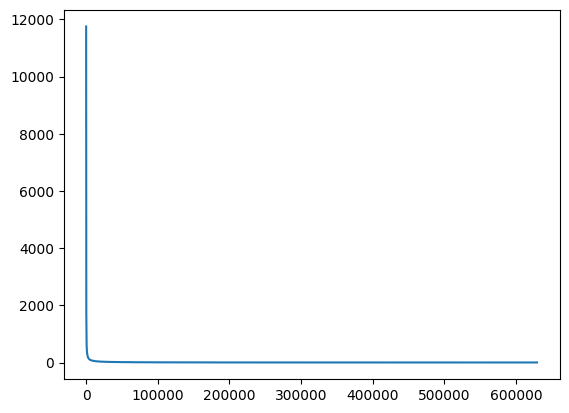

In [6]:
id2count = {k: v for k, v in df.value_counts('id').items()}  # очень полезная строчка!!!

freq_df = pd.DataFrame({'song_id': df.id.drop_duplicates().values})

counts = freq_df.song_id.apply(lambda song_id: id2count[song_id])
freq_df['count'] = counts
freq_df = freq_df.sort_values(by='count', ascending=False)
testment_item_counter = freq_df.copy()

fig, ax = plt.subplots()
ax.plot(np.arange(629330), freq_df['count'].values)
plt.show()

In [7]:
freq_df.describe()

,song_id,count
count,6.293300e+05,629330.000000
mean,-2.697644e+15,7.818003
std,5.326686e+18,83.430537
min,-9.223320e+18,1.000000
25%,-4.614309e+18,1.000000
50%,-3.800189e+15,1.000000
75%,4.611538e+18,3.000000
max,9.223354e+18,11751.000000


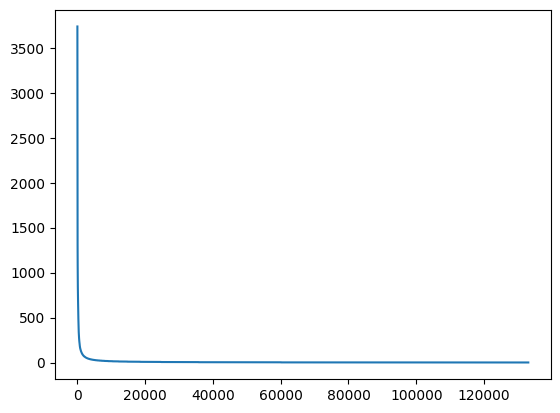

In [8]:
id2count = {k: v for k, v in submission_for_tests.value_counts('item_id').items()}

freq_df = pd.DataFrame({'song_id': submission_for_tests.item_id.drop_duplicates().values})

counts = freq_df.song_id.apply(lambda song_id: id2count[song_id])
freq_df['count'] = counts
freq_df = freq_df.sort_values(by='count', ascending=False)

fig, ax = plt.subplots()
ax.plot(np.arange(133060), freq_df['count'].values)
plt.show()

In [9]:
freq_df.describe()

,song_id,count
count,1.330600e+05,133060.000000
mean,-2.262370e+16,8.768135
std,5.327944e+18,58.298487
min,-9.223272e+18,1.000000
25%,-4.655324e+18,1.000000
50%,-2.189376e+16,2.000000
75%,4.584716e+18,5.000000
max,9.223354e+18,3737.000000


In [ ]:
#users = users.loc[users["user_id"].isin(ratings["user_id"])].copy()

# вытягиваем фичи в одну колонку и метим
#user_features_frames = []
#for feature in ["sex", "age", "occupation"]:
#    feature_frame = users.reindex(columns=["user_id", feature])
#    feature_frame.columns = ["id", "value"]
#    feature_frame["feature"] = feature
#    user_features_frames.append(feature_frame)
#user_features = pd.concat(user_features_frames)

# если надо вытянуть фичи, надеюсь я будующий поймет как это сделать)))
# оригинальный датасет: [Columns.User, "sex", "age", "occupation"]

In [ ]:
dataset = Dataset.construct(
    df_ratings,
    # датасет фич
    item_features_df = df_songs_features,
    # к этим фичам будет применен One Hot Encoding
    cat_item_features = ["artistId"],
    # для `sparse` формата
    make_dense_item_features=False 
)

dataset_without_features = Dataset.construct(
    df_ratings,
    # для `sparse` формата
    make_dense_item_features=False 
)

# на будующие, если надо работать с юзер фичами просто надо заменить айтем на юзер
# можно запустить без фич просто дав ему рейтингс и все
# дататайм обязателен рофлсон

# **Random model**

In [18]:
from rectools.models import RandomModel

model = RandomModel()

model.fit(dataset)
recos = model.recommend(
    users= submission.userId.unique(), 
    dataset=dataset,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

2.4285270212201835e-06

# **Popular model**

In [10]:
from rectools.models import PopularModel

# Fit model and generate recommendations for all users

model = PopularModel()
model.fit(dataset)
recos = model.recommend(
    users= submission.userId.unique(), 
    dataset=dataset,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

0.005926177349899887

# **Popular In Category**

In [ ]:
from rectools.models.popular_in_category import PopularInCategoryModel

model = PopularInCategoryModel('artistId')
model.fit(dataset)
recos = model.recommend(
    users=Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)

MAP(k=3).calc(recos, submission_for_tests)

In [12]:
MAP(k=3).calc(recos, submission_for_tests)

0.005926177349899887

# **SVD**

In [11]:
# Особенности: резултат будет хуже чем ALS, использовать только как бейзлайн. Работа только с HOT датой
from rectools.models import PureSVDModel

# Fit model and generate recommendations for all users
model = PureSVDModel()
model.fit(dataset)
recos = model.recommend(
    users=Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)

MAP(k=3).calc(recos, submission_for_tests)

0.010673519112793366

# **ALS model**

In [ ]:
# Особенности: выдает очень даже неплохой результат сравнимый с катбустом. Работа только с HOT датой
# не использует фичи!!!
from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares

model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=8,    # базово стоит на 64, повышать если нужны выявлять более сложные соответствия
            regularization=0.01,
            alpha=1,     
            random_state=132,
            use_gpu= False,
            iterations=15,),
        fit_features_together=False,  # way to fit paired features
            )

model.fit(dataset)

recos = model.recommend(
    users=Hot_users_data,
    dataset=dataset_without_features,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

/opt/conda/lib/python3.10/site-packages/rectools/dataset/features.py:424: UserWarning: Converting sparse features to dense array may cause MemoryError
  warnings.warn("Converting sparse features to dense array may cause MemoryError")


# **KNN**

In [10]:
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import TFIDFRecommender

model = ImplicitItemKNNWrapperModel(
        model=TFIDFRecommender(K=5)
        )

model.fit(dataset)

recos = model.recommend(
    users=Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

0.012836622416047246

# **EASE**

In [ ]:
from rectools.models import EASEModel

model = EASEModel(regularization=500)

model.fit(dataset)
recos = model.recommend(
    users = Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)

MAP(k=3).calc(recos, submission_for_tests)

# **LightFM**

In [32]:
from rectools.models import LightFMWrapperModel
from lightfm import LightFM

model = LightFMWrapperModel(
        # внутри модели указываем параметр no_components
        # это размезность эмбеддингов, которые выучит модель
        model=LightFM(no_components = 30),
        )

model.fit(dataset)
recos = model.recommend(
    users = Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
MAP(k=3).calc(recos, submission_for_tests)

In [33]:
MAP(k=3).calc(recos, submission_for_tests)

0.004196494692668478

#  **DSSM**

In [34]:
from rectools.models import DSSMModel

model = DSSMModel(dataset, 
                  max_epochs = 10,
                  batch_size = 64
                 )
model.fit(dataset)
recos = model.recommend(
    users = Hot_users_data,
    dataset=dataset,
    k=3,
    filter_viewed=True,
)
MAP(k=3).calc(recos, submission_for_tests)

ValueError: DSSM model requires user and item features to be present in the dataset.

# **Эксперементы**

**№1 Идея: запихнуть в модели только популярные items.**

In [21]:
id2count = {k: v for k, v in df.value_counts('id').items()}  
testment_item_counter = pd.DataFrame({'song_id': df.id.drop_duplicates().values})
counts = testment_item_counter.song_id.apply(lambda song_id: id2count[song_id])
testment_item_counter['count'] = counts
testment_item_counter = testment_item_counter.sort_values(by='count', ascending=False)

testment_item_counter = testment_item_counter[testment_item_counter['count'] > testment_item_counter['count'].quantile(.99)] # катает n процентов датасета начиная с конца

df_ratings_ALS_popular_item = df_ratings[df_ratings['item_id'].isin(testment_item_counter['song_id'])]

print('Было данных: ' + str(len(df_ratings)) + ' осталось данных: ' +  str(len(df_ratings_ALS_popular_item)) + ' Осталось в %: ' + str(100 * len(df_ratings_ALS_popular_item)/len(df_ratings)))
                                         
dataset_without_features_popular_items = Dataset.construct(
    df_ratings_ALS_popular_item,
    # для `sparse` формата
    make_dense_item_features=False 
)  

hot_users_popular_items = submission[submission['userId'].isin(df_ratings_ALS_popular_item[Columns.User])].userId.unique()

Было данных: 4920104 осталось данных: 2299319 Осталось в %: 46.73313816130716


In [22]:
from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares

model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=64,    # базово стоит на 64, повышать если нужны выявлять более сложные соответствия
            regularization=0.01,
            alpha=1,     
            random_state=132,
            use_gpu= False,
            iterations=15,),
        fit_features_together=False,  # way to fit paired features
            )

model.fit(dataset_without_features_popular_items)

recos = model.recommend(
    users=hot_users_popular_items,
    dataset=dataset_without_features_popular_items,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

0.00904740599029046

In [64]:
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import TFIDFRecommender

model = ImplicitItemKNNWrapperModel(
        model=TFIDFRecommender(K=3)
        )

model.fit(dataset_without_features_popular_items)

recos = model.recommend(
    users=hot_users_popular_items,
    dataset=dataset_without_features_popular_items,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

0.017051545343170868

In [66]:
from rectools.models import EASEModel

model = EASEModel(regularization=500)

model.fit(dataset_without_features_popular_items)
recos = model.recommend(
    users = hot_users_popular_items,
    dataset=dataset_without_features_popular_items,
    k=3,
    filter_viewed=True,
)

MAP(k=3).calc(recos, submission_for_tests)

0.01929650429249293

**№2 Идея: запихнуть в модели только популярные Users.**

In [16]:
id2count = {k: v for k, v in df.value_counts('userId').items()}  
testment_user_counter = pd.DataFrame({'user_id': df.userId.drop_duplicates().values})
counts = testment_user_counter.user_id.apply(lambda song_id: id2count[song_id])
testment_user_counter['count'] = counts
testment_user_counter = testment_user_counter.sort_values(by='count', ascending=False)

testment_user_counter = testment_user_counter[testment_user_counter['count'] > testment_user_counter['count'].quantile(.90)] # катает n процентов датасета начиная с конца

df_ratings_ALS_popular_user = df_ratings[df_ratings['user_id'].isin(testment_user_counter['user_id'])]

print('Было данных: ' + str(len(df_ratings)) + ' осталось данных: ' +  str(len(df_ratings_ALS_popular_user)) + ' Осталось в %: ' + str(100 * len(df_ratings_ALS_popular_user)/len(df_ratings)))
                                         
dataset_without_features_popular_user = Dataset.construct(
    df_ratings_ALS_popular_user,
    # для `sparse` формата
    make_dense_item_features=False 
)  

hot_users_popular_user = submission[submission['userId'].isin(df_ratings_ALS_popular_user[Columns.User])].userId.unique()

Было данных: 4920104 осталось данных: 3006532 Осталось в %: 61.10708228931746


In [19]:
from rectools.models import ImplicitALSWrapperModel
from implicit.als import AlternatingLeastSquares

model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=64,    # базово стоит на 64, повышать если нужны выявлять более сложные соответствия
            regularization=0.01,
            alpha=1,     
            random_state=132,
            use_gpu= False,
            iterations=15,),
        fit_features_together=False,  # way to fit paired features
            )

model.fit(dataset_without_features_popular_user)

recos = model.recommend(
    users=hot_users_popular_user,
    dataset=dataset_without_features_popular_user,
    k=3,
    filter_viewed=True,
)


MAP(k=3).calc(recos, submission_for_tests)

0.0031246571491264155